In [5]:
import sys
import os
sys.path.append(os.path.relpath('../../'))
sys.path.append(os.path.relpath('../'))

from helpers import *
import numpy as np
import matplotlib.colors as mcolors

In [6]:
# filename definitions
file1 = "data/MEEM-sweep.pkl"
file2 = "data/CPT.pkl"
file3 = "data/pair-comparison.pkl"

In [7]:
# base variables and variable ranges
base_spar_rad = 3
base_float_rad = 10
base_spar_depth = 35
base_float_depth = 3
base_h = 70
rho = 1023

# Do a frequency sweep for all geoms
m0s = (list(np.round(np.linspace(0.001, 0.009, 9), 3))
      + list(np.round(np.linspace(0.01, 0.09, 9), 3))
      + list(np.round(np.linspace(0.1, 1.1, 11), 3)))

# Variations
spar_rads = np.linspace(1.5, 6, 10)
float_rads = np.linspace(5, 15, 11)
spar_depths = np.linspace(20, 50, 13)
float_depths = np.linspace(1.5, 6, 10)
hs = np.linspace(40, 100, 13)

# Convergence
big_nmk, nmk_max = 200, 150

min_period, max_period = 4.5, 18.5
min_angular_freq, max_angular_freq = 2 * np.pi/max_period, 2 * np.pi/min_period

In [8]:
# To each [geom][m0][heave][region], add 1% convergence point, alpha, and beta for each hydro coeff (function defs).
def add_convergence_point(region_dict, true_vals):
  hydro_keys = ["am", "dp"]
  for hydro in hydro_keys:
    true_value = true_vals[hydro]
    hydros = region_dict[hydro + "s"]
    incumbent = len(hydros)
    for nmk in range(len(hydros), 0, -1):
      if abs((hydros[nmk - 1] - true_value)/true_value) <= 0.01:
        incumbent = nmk
      else:
        break
    region_dict["convergence point 0.01 " + hydro] = incumbent

def add_log_errors(region_dict, true_vals):
  hydro_keys = ["am", "dp"]
  for hydro in hydro_keys:
    true_value = true_vals[hydro]
    ys = [np.log(abs(entry - 1)) for entry in scale_by(region_dict[hydro + "s"], true_value)]
    region_dict["log errors " + hydro] = ys

def add_alpha_beta(region_dict, true_vals):
  hydro_keys = ["am", "dp"]
  xs = list(range(1, nmk_max + 1))
  f = lambda x, a1, a2 : (- a1 * np.log(x/a2))
  for hydro in hydro_keys:
    ys = [region_dict["log errors " + hydro][i] for i in range(nmk_max)]
    popt, pcov = curve_fit(f, xs, ys, p0=(1, 1))
    alpha, beta = popt[0], popt[1]
    region_dict["alpha " + hydro], region_dict["beta " + hydro] = alpha, beta

def add_func_vals(data_dict, func):
  for m0 in data_dict["m0s"]:
    for heave in [0, 1]:
      true_am, true_dp = data_dict[m0][heave]["am"], data_dict[m0][heave]["dp"]
      for region in [0, 1, 2]:
        func(data_dict[m0][heave][region], {"am" : true_am, "dp" : true_dp})

In [ ]:
# Import all data and add convergence points, alpha, beta, log errors to first file
meem_data = open_pkl_file(file1)
cpt_data = open_pkl_file(file2)
comparison_data = open_pkl_file(file3)

for subset in meem_data:
  for data_dict in subset:
    add_func_vals(data_dict, add_convergence_point)
    add_func_vals(data_dict, add_log_errors)
    add_func_vals(data_dict, add_alpha_beta)

In [10]:
# Plotting helper functions:
geometry_fs = {"spar radius" : lambda cf : cf["a"][0],
               "float radius" : lambda cf : cf["a"][1],
               "spar depth" : lambda cf : cf["d"][0],
               "float depth" : lambda cf : cf["d"][1],
               "h" : lambda cf : cf["h"]}

dimless_fs = {"spar (h-d)/radwidth" : lambda cf : ((cf["h"] - cf["d"][0])/cf["a"][0]),
              "float (h-d)/radwidth" : lambda cf : ((cf["h"] - cf["d"][0])/cf["a"][0])}

region_colors = [plt.get_cmap('tab10')(i) for i in [0, 2, 1]]

number_to_region = {0 : "spar", 1 : "float", 2 : "exterior"}
full_name = {"am" : "added mass", "dp" : "damping"}

def adjust_intensity(color, level, vmin=1, vmax=10):
    """Return color lightened according to intensity level."""
    white = np.array([1, 1, 1])
    base = np.array(mcolors.to_rgb(color))
    factor = (level - vmin) / (vmax - vmin)  # 0–1
    return base * factor + white * (1 - factor)

def plot_against_geometry(subset, geo_f, geo_label, val_label, y_label, hydro, m0):
    xs = [geo_f(cf) for cf in subset]
    all_ys = [[[cf[m0][heave][region][val_label + " " + hydro] for cf in subset] for region in [0, 1, 2]] for heave in [0, 1]]
    for region in [0, 1, 2]:
        plt.plot(xs, all_ys[0][region], linestyle = "--", color = region_colors[region],
                 label = (number_to_region[region] + " region, " +  number_to_region[0] + " heaving"))
    for region in [0, 1, 2]:
        plt.plot(xs, all_ys[1][region], linestyle = "-", color = region_colors[region],
                 label = (number_to_region[region] + " region, " +  number_to_region[1] + " heaving"))
    plt.xlabel(geo_label)
    plt.ylabel(y_label)
    plt.title(y_label + " for " + full_name[hydro])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def plot_all_m0s_against_geometry(subset, geo_f, geo_label, val_label, y_label, hydro, m0s):
    xs = [geo_f(cf) for cf in subset]
    all_ys = [[[[cf[m0][heave][region][val_label + " " + hydro] for cf in subset]
                for region in [0, 1, 2]]
                for heave in [0, 1]]
                for m0 in m0s]
    
    intensities = list(range(2, len(m0s) + 1))
    linestyles = {0 : "--", 1 : "-"}

    for region in [0, 1, 2]:
        for i in range(len(m0s) - 1):
            plt.plot(xs, all_ys[i][0][region], linestyle = linestyles[0],
                     color = adjust_intensity(region_colors[region], intensities[i], vmin = 1, vmax = intensities[-1]))
    for region in [0, 1, 2]:
        plt.plot(xs, all_ys[i][1][region], linestyle = linestyles[1],
                 color = adjust_intensity(region_colors[region], intensities[i], vmin = 1, vmax = intensities[-1]))
    
    for region in [0, 1, 2]:
        plt.plot(xs, all_ys[-1][0][region], linestyle = linestyles[0],
                 color = adjust_intensity(region_colors[region], intensities[-1], vmin = 1, vmax = intensities[-1]))
    for region in [0, 1, 2]:
        plt.plot(xs, all_ys[-1][1][region], linestyle = linestyles[1],
                 color = adjust_intensity(region_colors[region], intensities[-1], vmin = 1, vmax = intensities[-1]))
        
    handles = []
    labels = []

    for region in [0, 1, 2]:
        for heave in [0, 1]:
            line = plt.Line2D([0], [0],
                            color=region_colors[region],
                            linestyle=linestyles[heave],
                            linewidth=2)
            handles.append(line)
            labels.append(number_to_region[region] + " region, " +  number_to_region[heave] + " heaving")
    
    plt.xlabel(geo_label)
    plt.ylabel(y_label)
    plt.title(y_label + " for " + full_name[hydro])
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

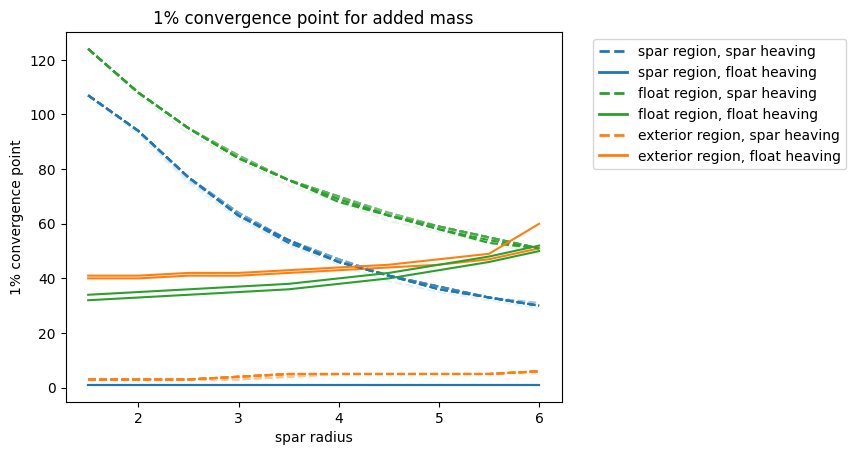

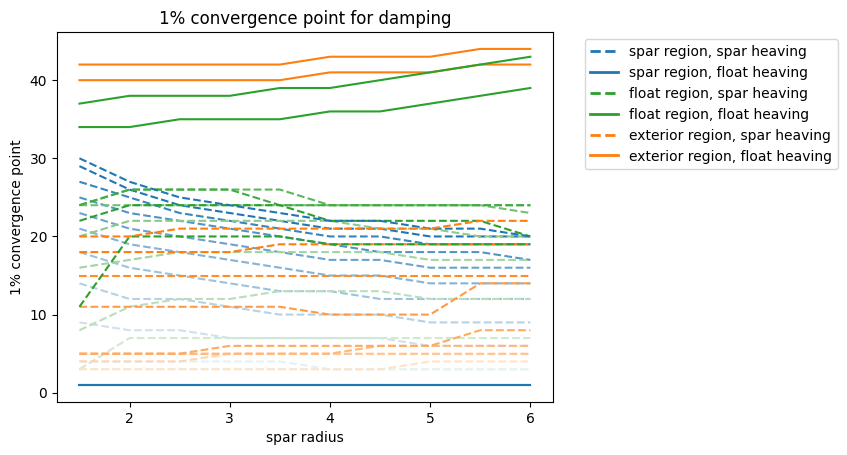

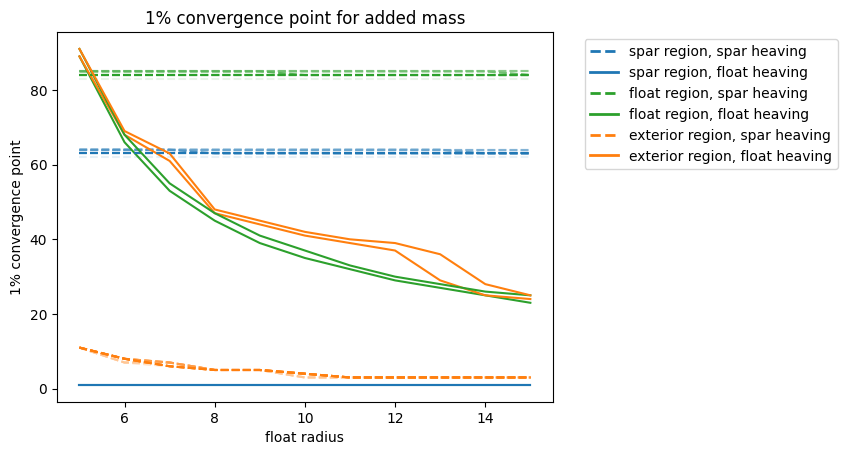

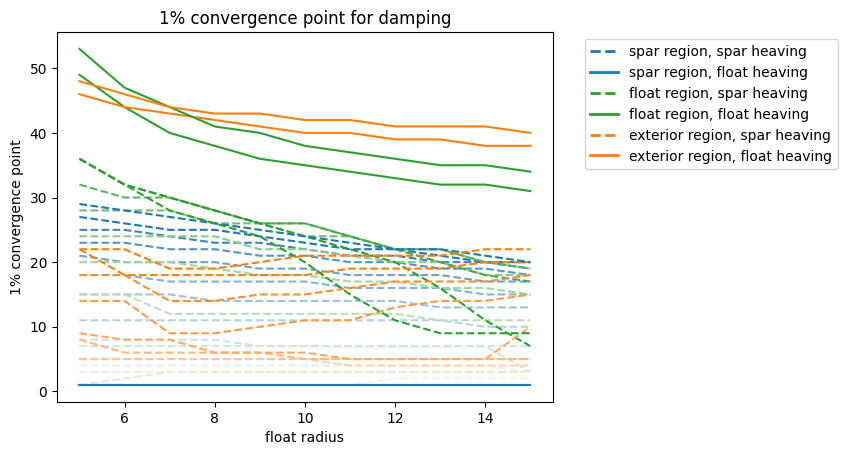

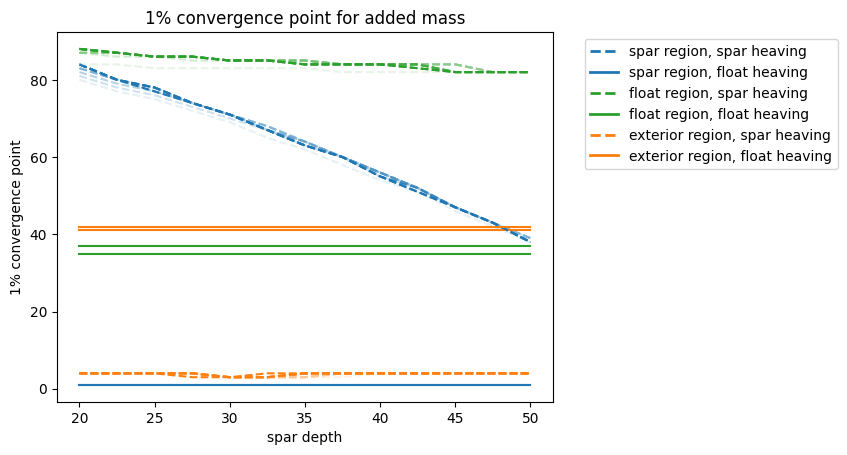

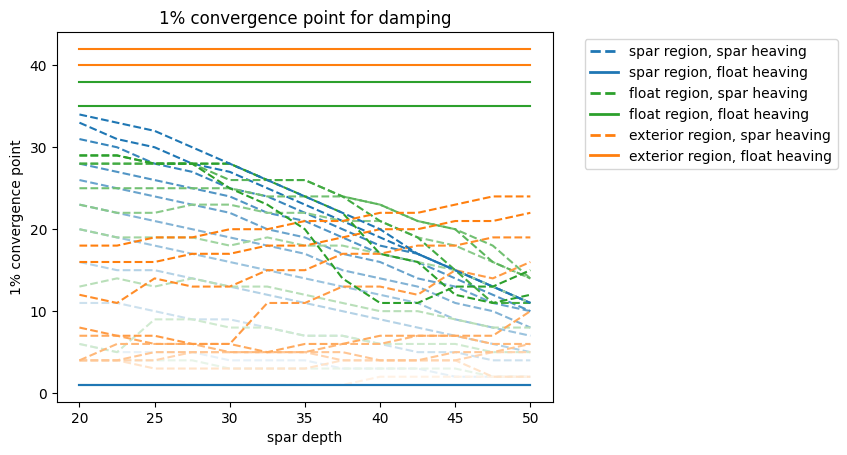

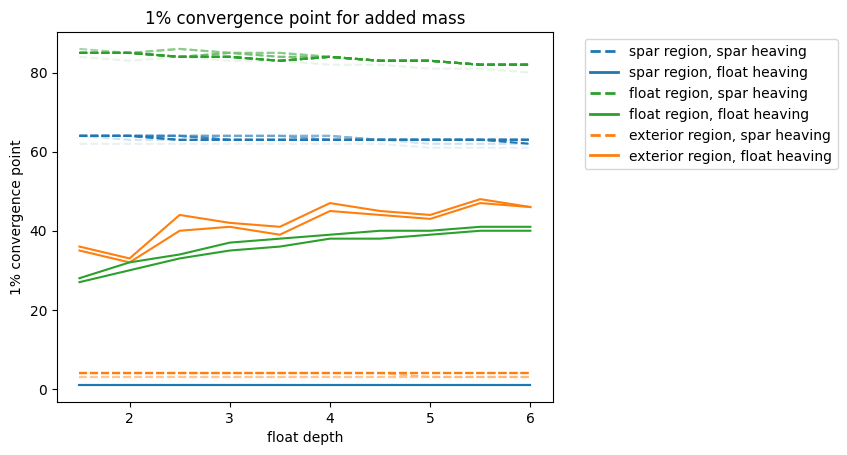

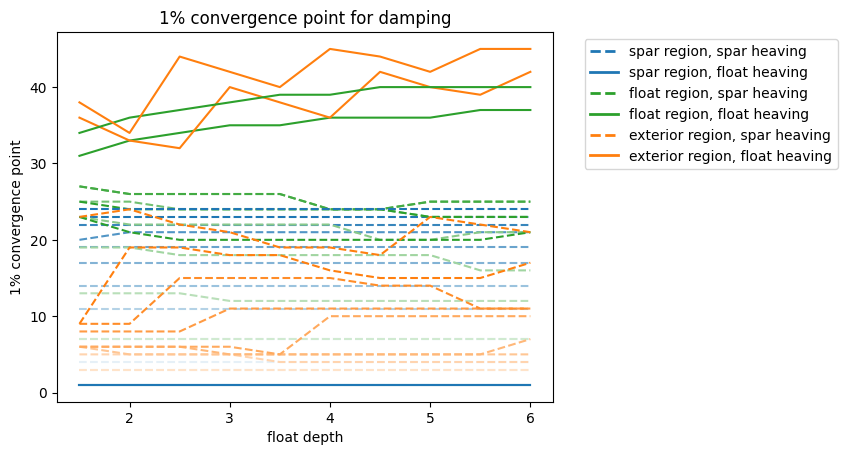

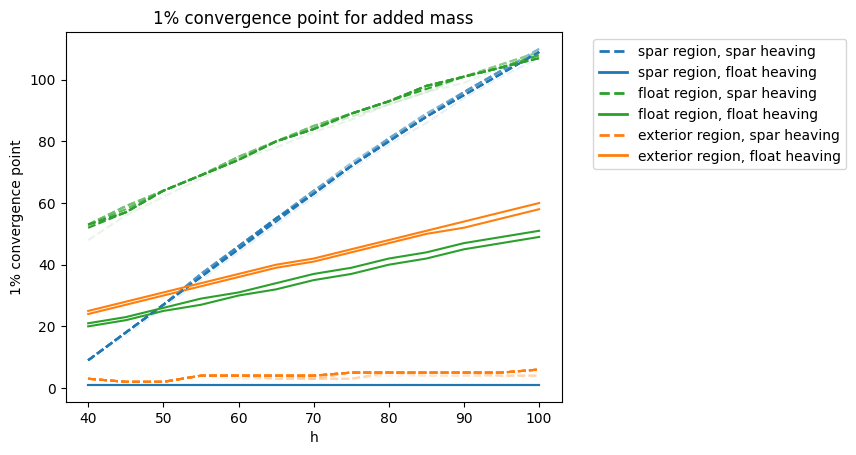

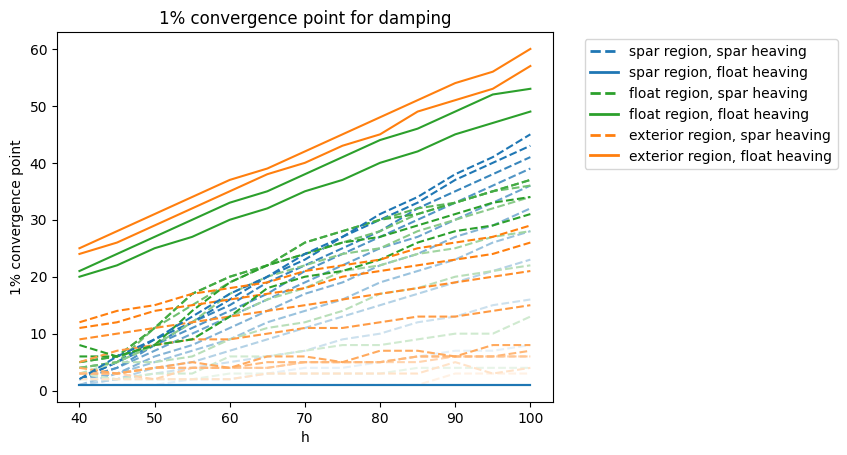

In [ ]:
# Plot convergence points, multiple m0s, across geometries
geo_labels = list(geometry_fs.keys())
for idx, geo_label in enumerate(geo_labels):
  for hydro in ["am", "dp"]:
    plot_all_m0s_against_geometry(meem_data[idx], geometry_fs[geo_label], geo_label,
                          "convergence point 0.01", "1% convergence point", hydro, m0s[9:19])

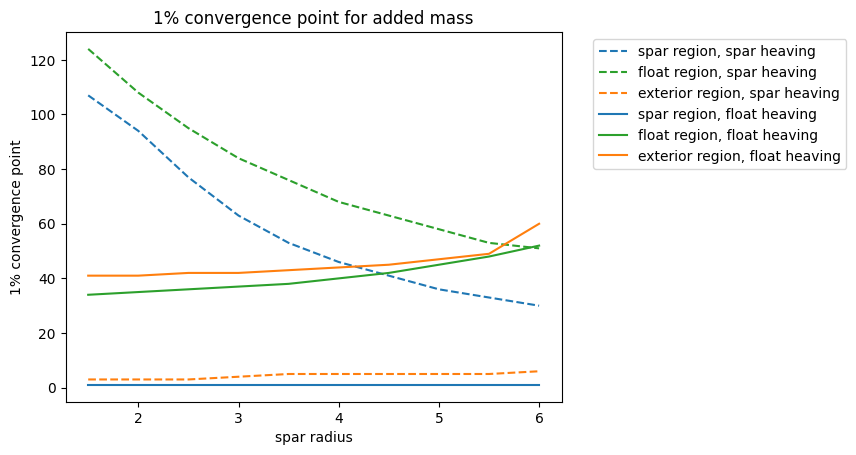

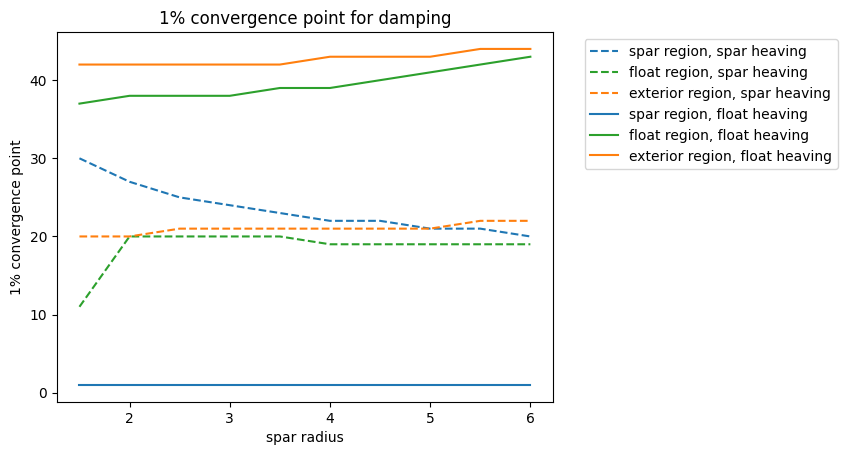

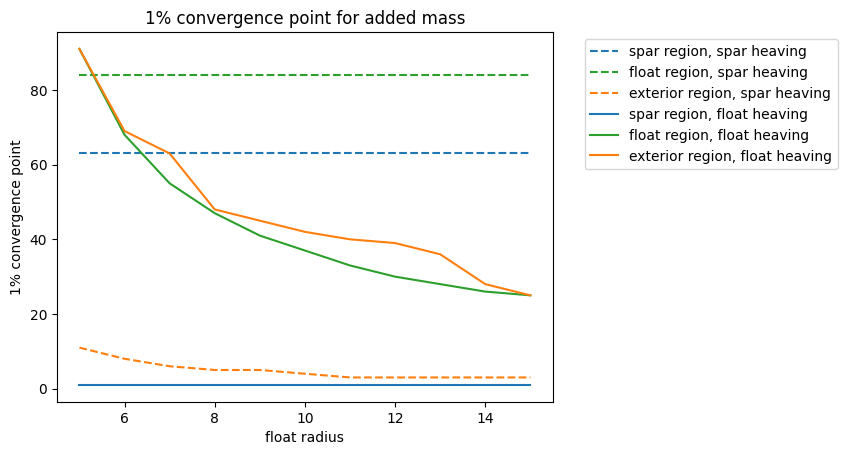

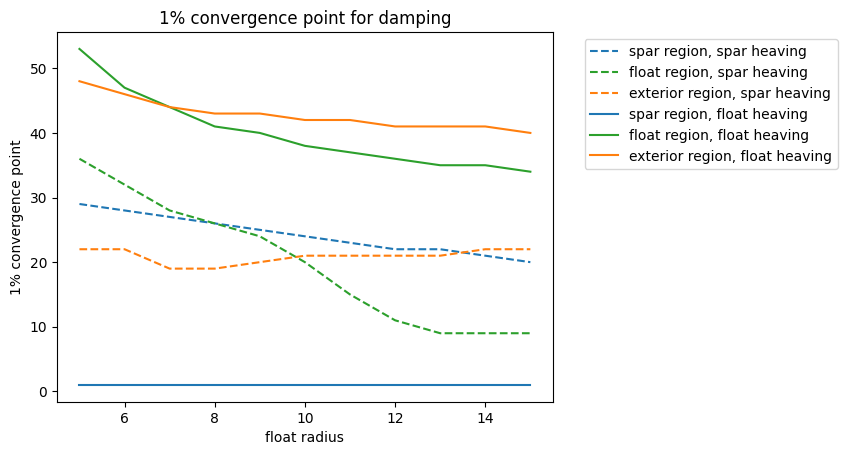

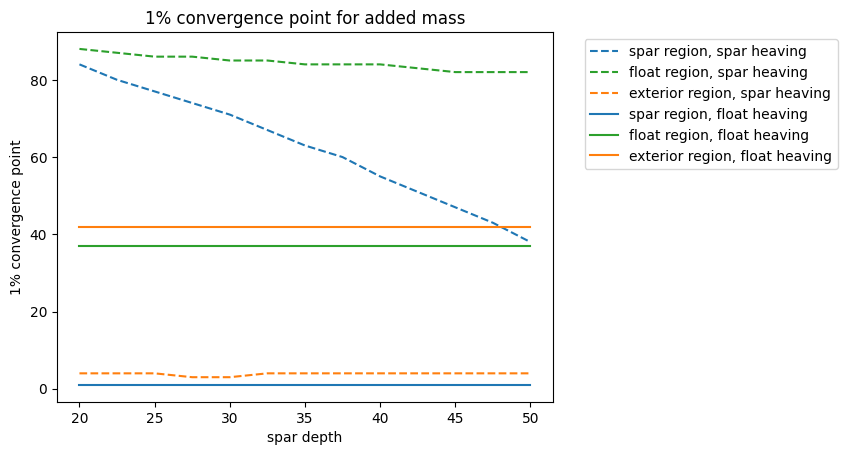

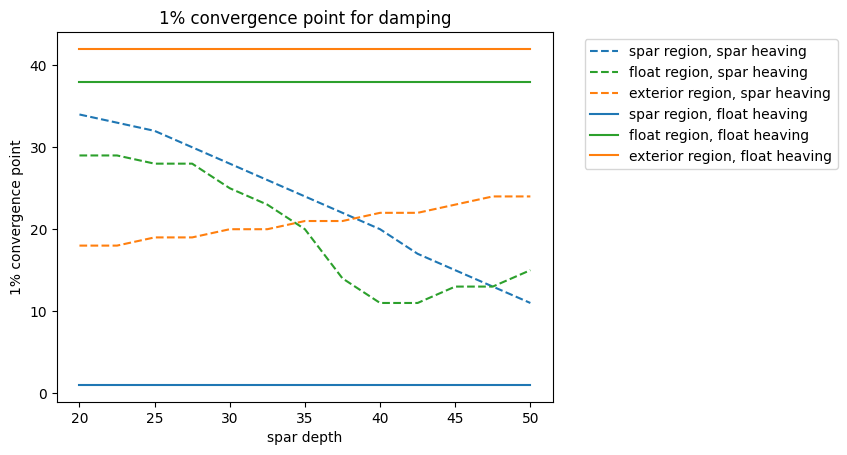

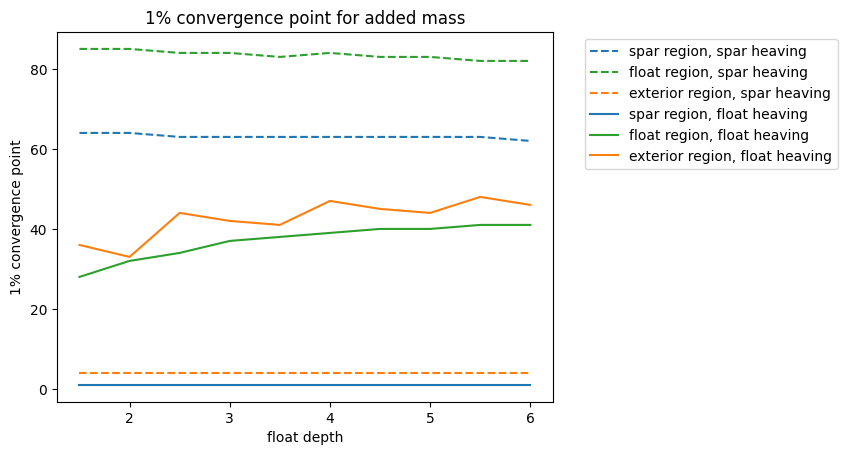

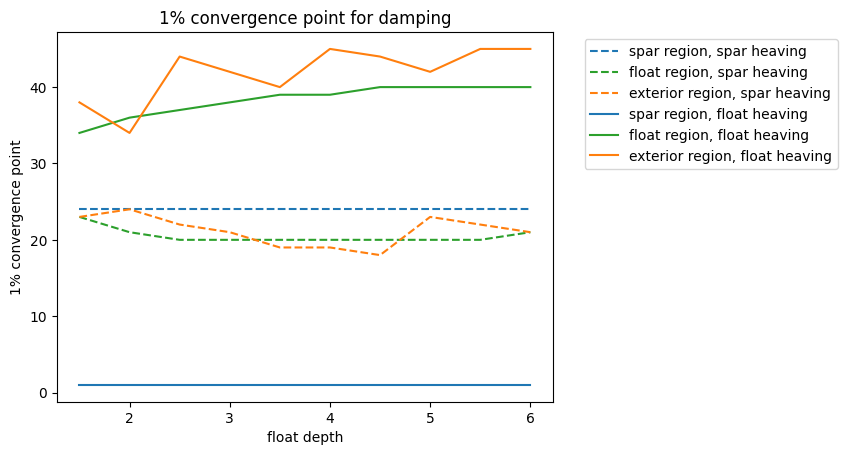

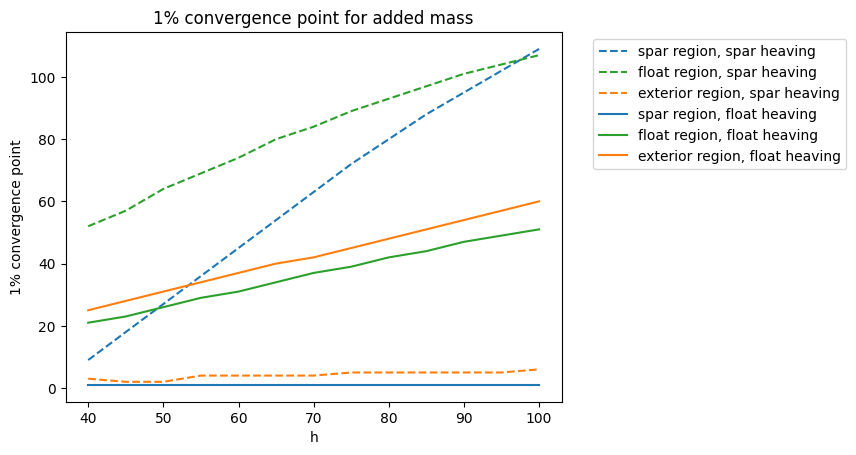

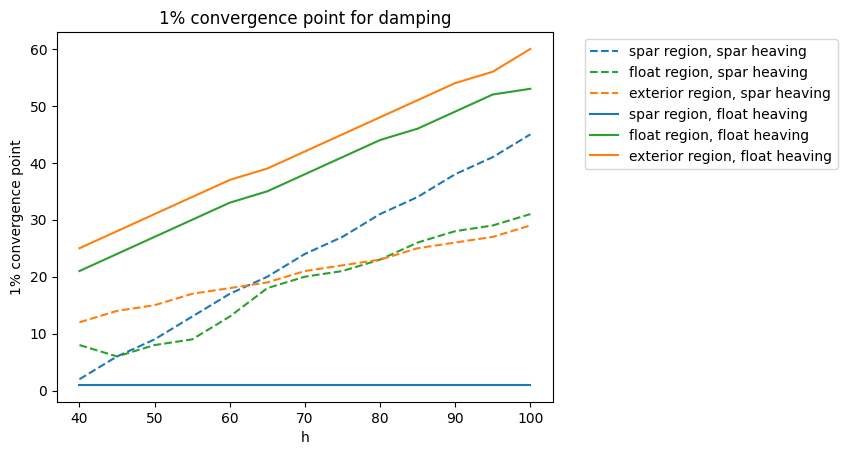

In [ ]:
# Plot convergence points, m0 = 0.1, across geometries
geo_labels = list(geometry_fs.keys())
for idx, geo_label in enumerate(geo_labels):
  for hydro in ["am", "dp"]:
    plot_against_geometry(meem_data[idx], geometry_fs[geo_label], geo_label,
                          "convergence point 0.01", "1% convergence point", hydro, m0 = 0.1)
  

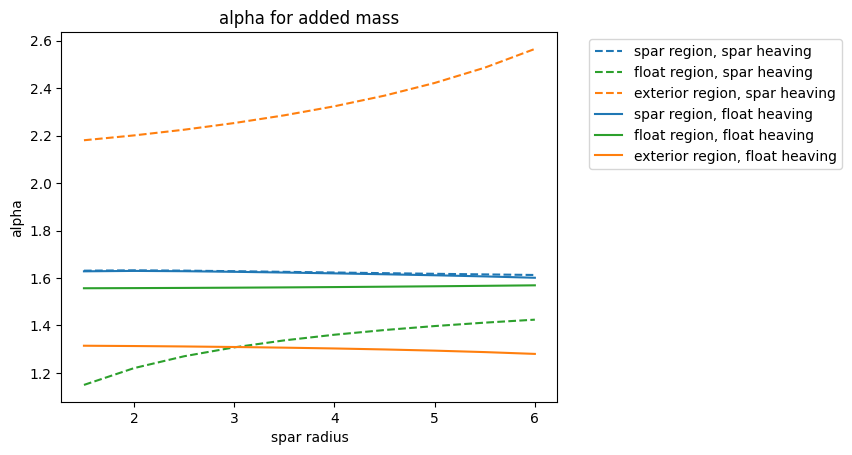

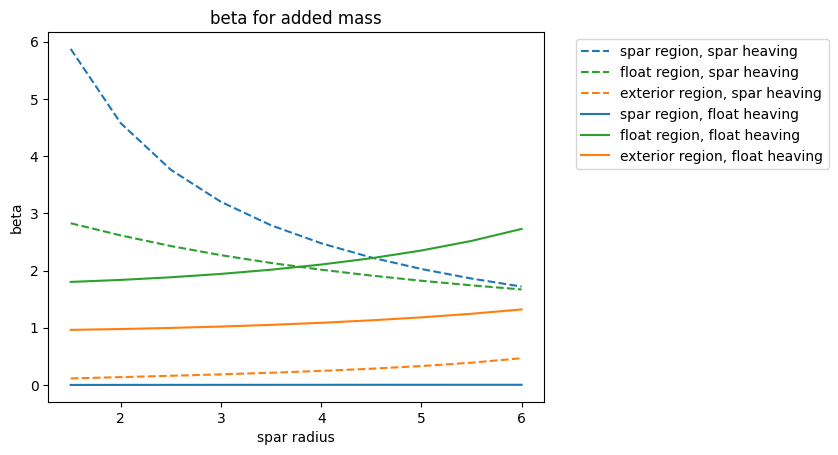

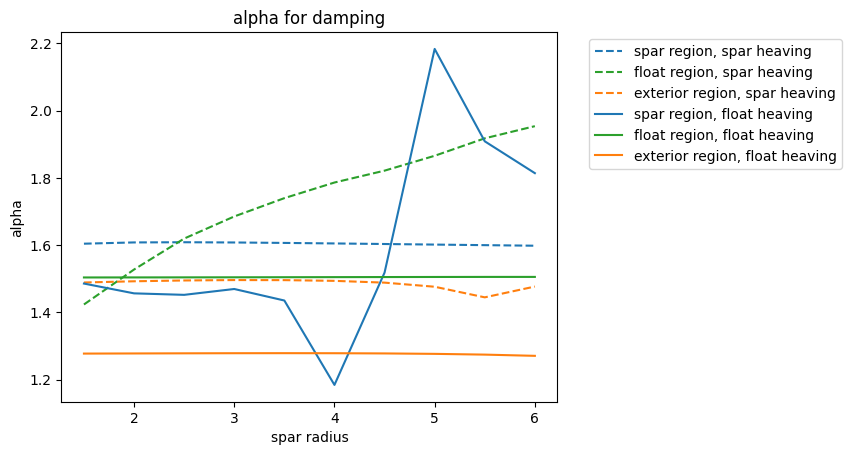

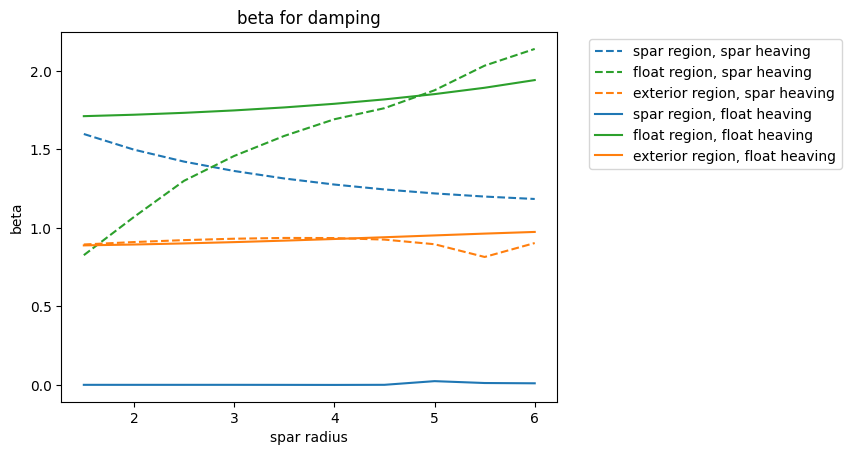

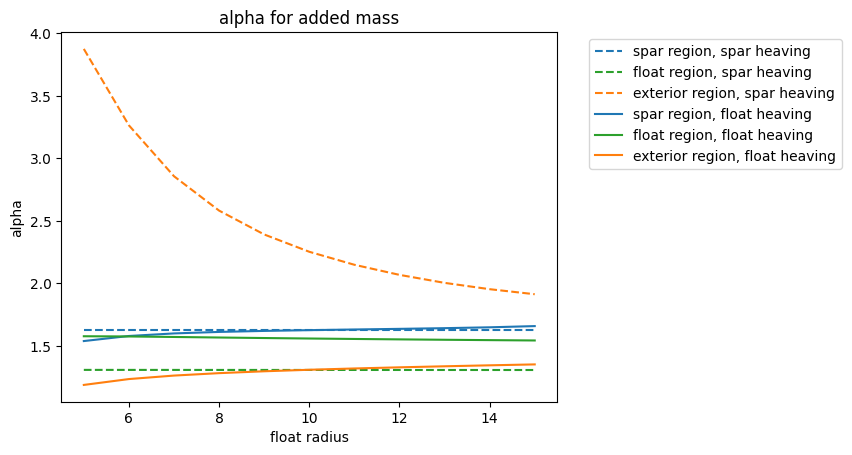

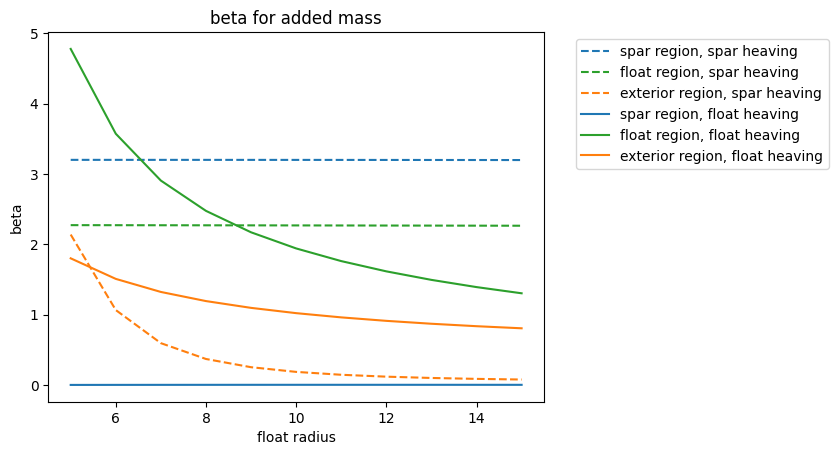

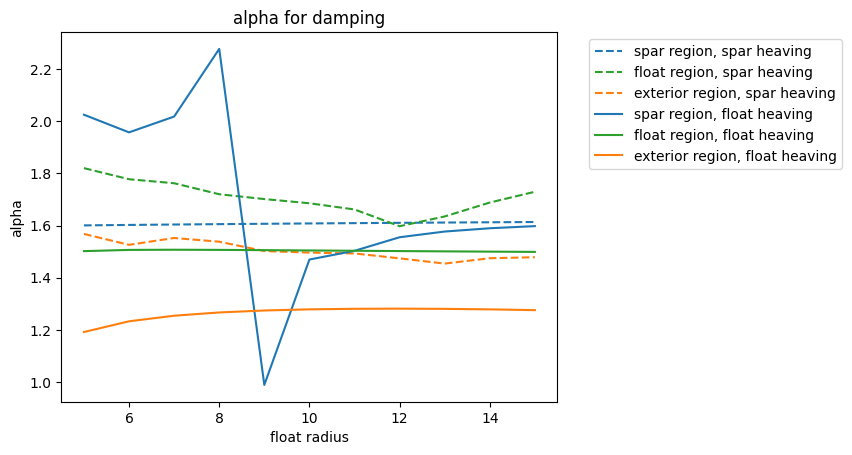

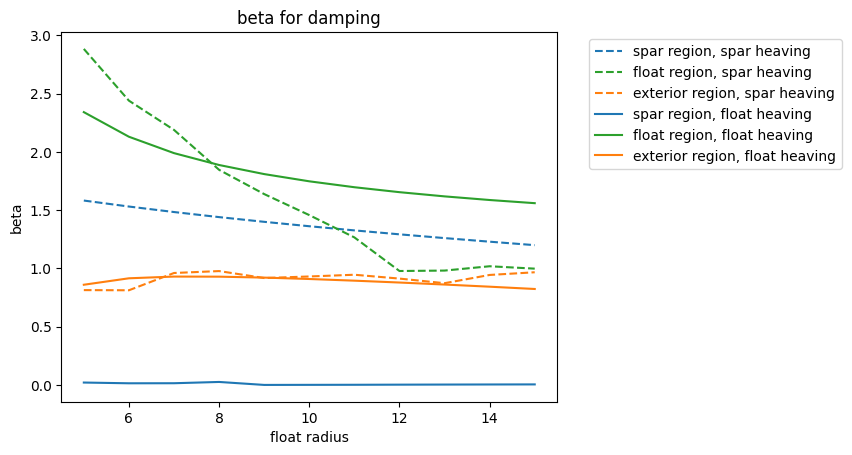

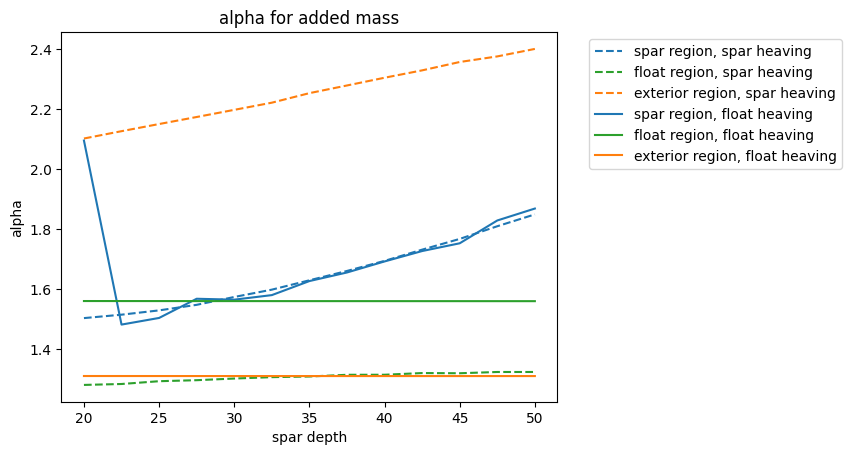

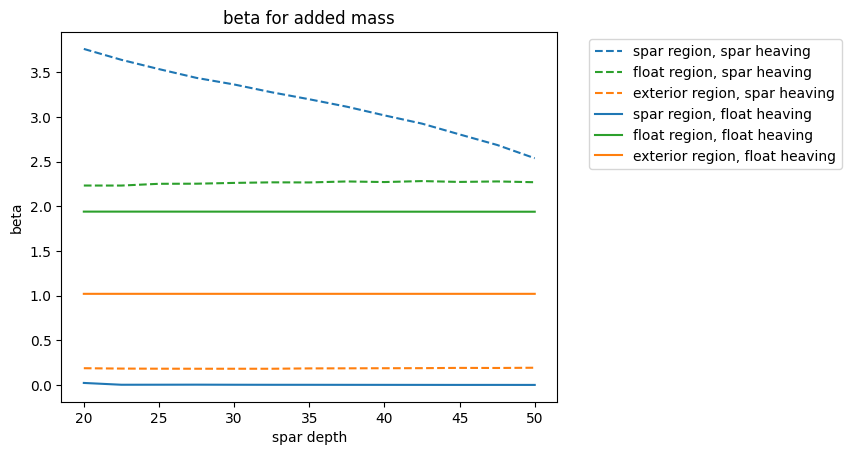

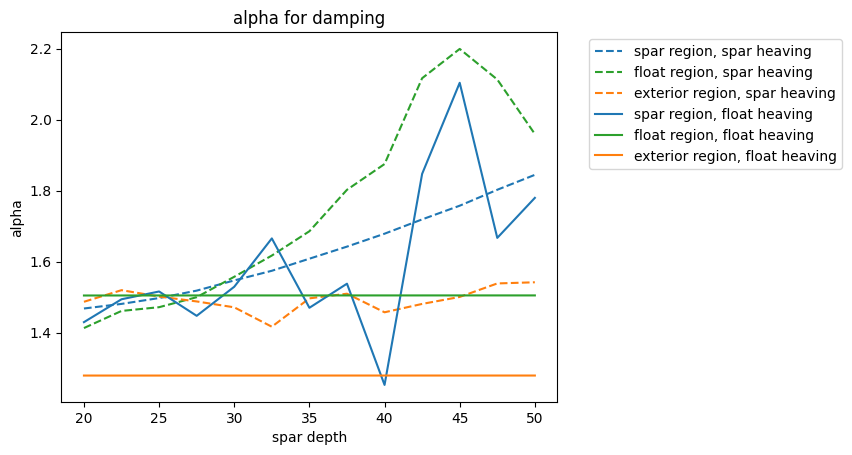

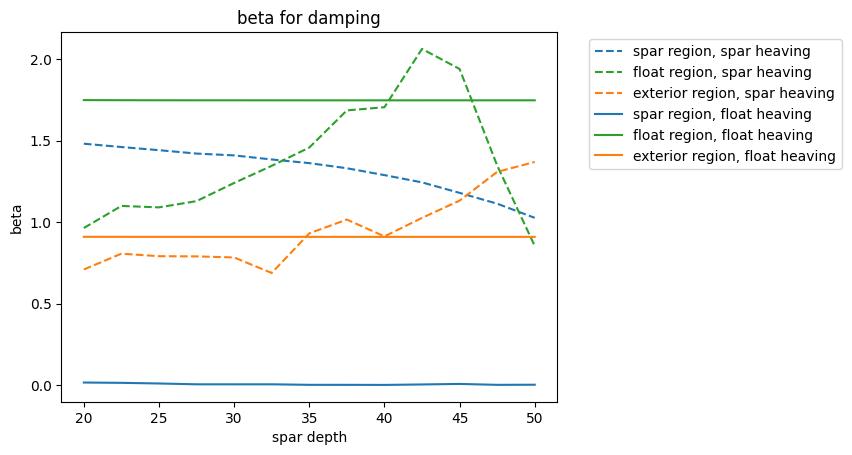

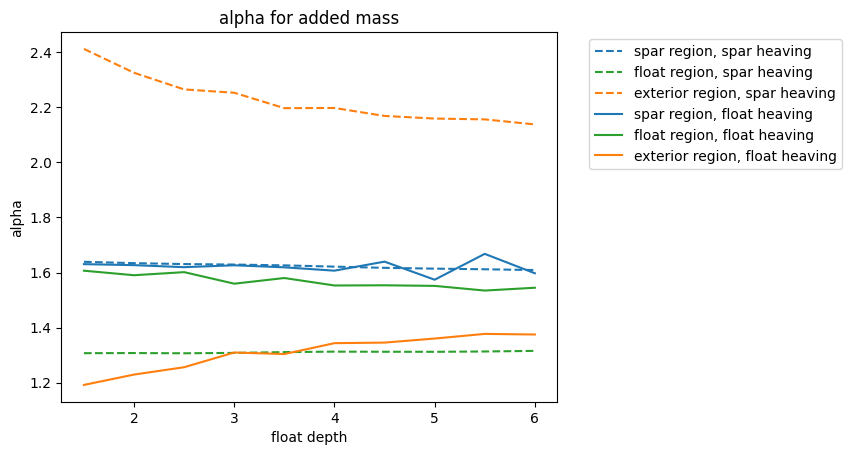

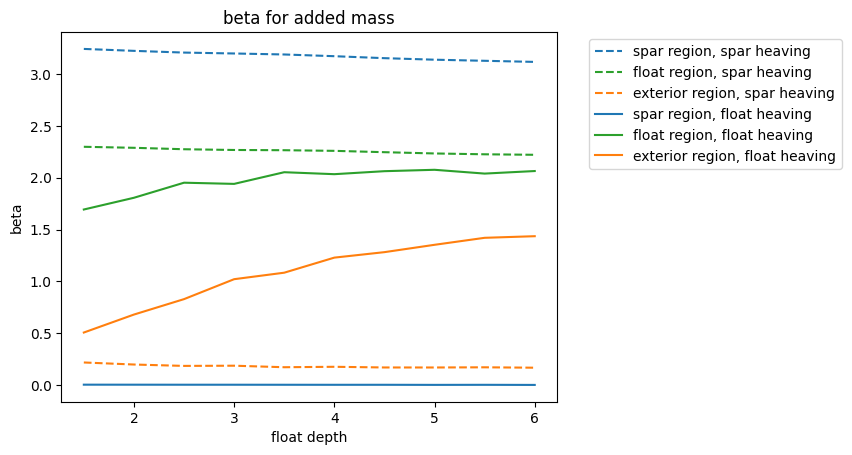

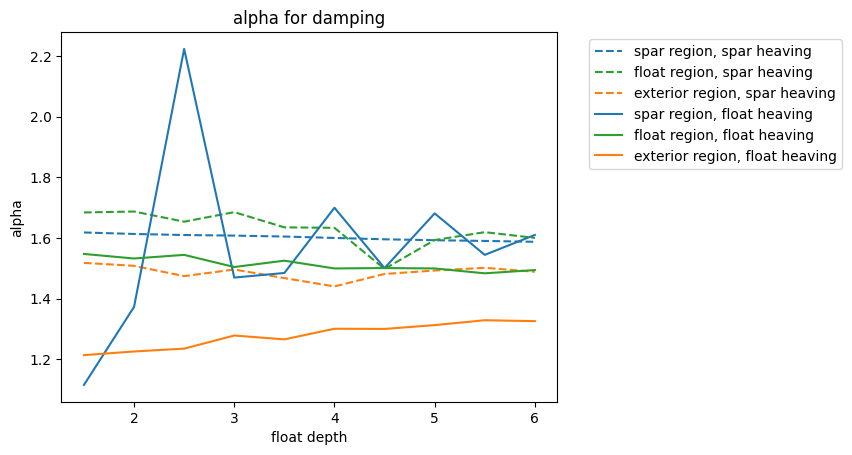

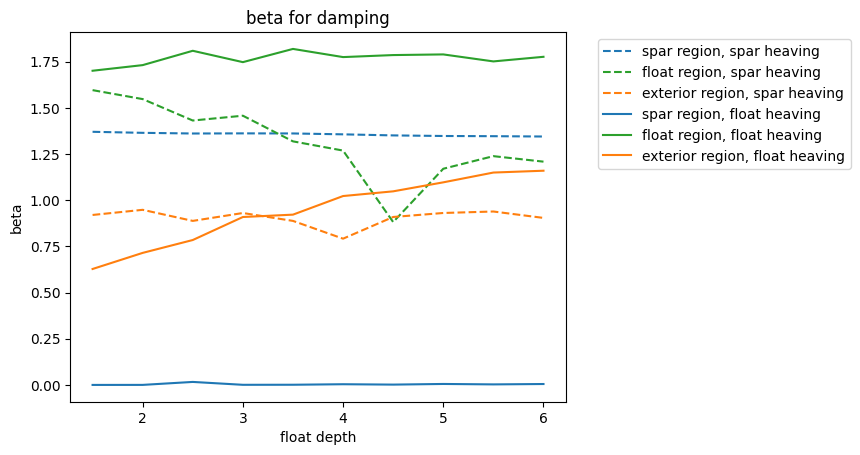

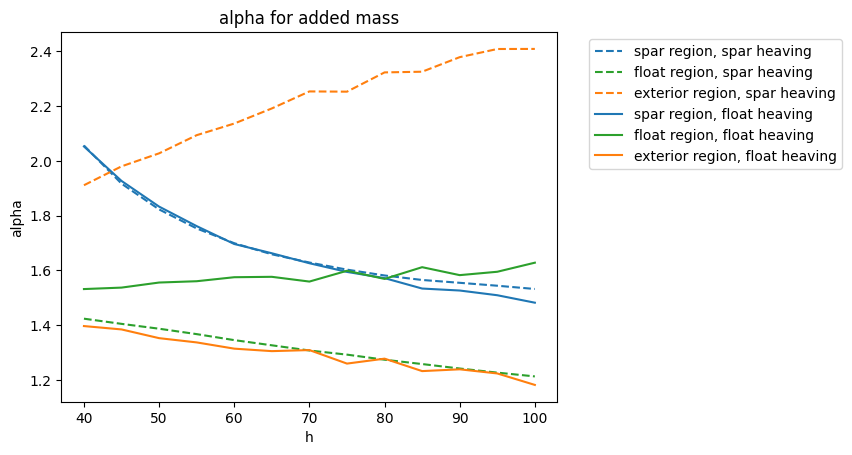

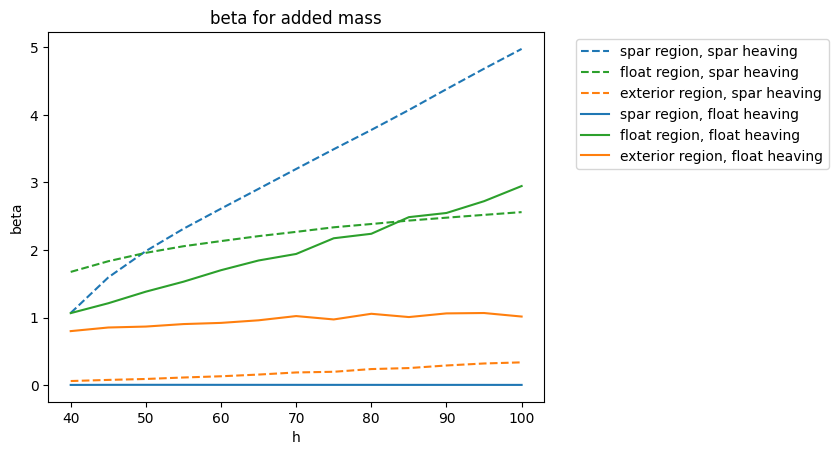

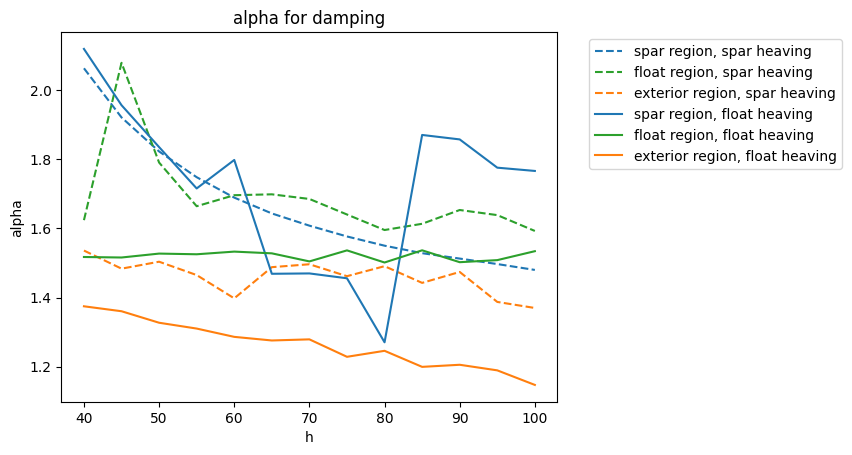

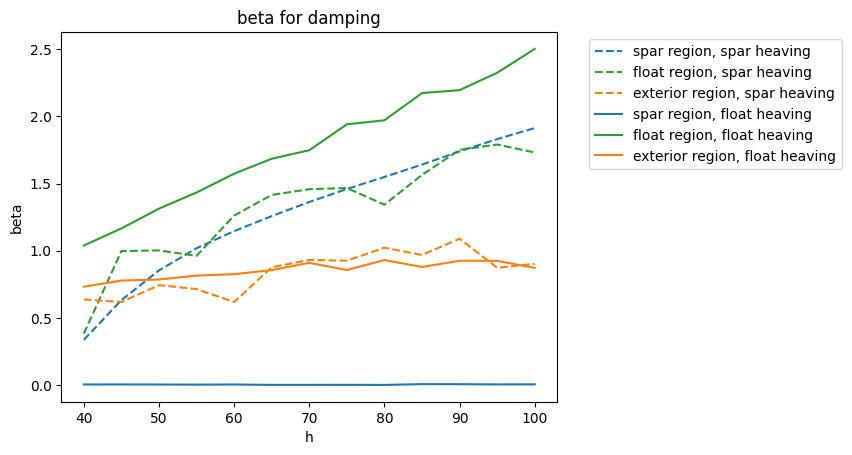

In [ ]:
# Plot alpha, beta, across geometries
geo_labels = list(geometry_fs.keys())
for idx, geo_label in enumerate(geo_labels):
  for hydro in ["am", "dp"]:
    plot_against_geometry(meem_data[idx], geometry_fs[geo_label], geo_label,
                          "alpha", "alpha", hydro, m0 = 0.1)
    plot_against_geometry(meem_data[idx], geometry_fs[geo_label], geo_label,
                          "beta", "beta", hydro, m0 = 0.1)

In [ ]:
# file 2 & 3 helper functions
def get_nmks(meem_lst):
  output = []
  for entry in meem_lst:
    nmk = entry["NMK"]
    nmk_total = nmk[0] + 2 * nmk[1] + nmk[2]
    output.append(nmk_total)
  return output

def get_panel_counts(cpt_lst):
  return [cpt_entry["Panel Count"] for cpt_entry in cpt_lst]

def get_fraction_off_vals(lst, heave, hydro, true_val):
  output = []
  for entry in lst:
    val = entry[heave][hydro]
    output.append((val - true_val)/true_val)
  return output

def get_plottable_info(data, index, base, m0):
  am0, am1, dp0, dp1 = base[m0][0]["am"], base[m0][1]["am"], base[m0][0]["dp"], base[m0][1]["dp"]

  return {"NMKs" : get_nmks(data[index]["MEEM"]),
          "MEEM 0 am" : get_fraction_off_vals(data[index]["MEEM"], 0, "am", am0),
          "MEEM 0 dp" : get_fraction_off_vals(data[index]["MEEM"], 0, "dp", dp0),
          "MEEM 1 am" : get_fraction_off_vals(data[index]["MEEM"], 1, "am", am1),
          "MEEM 1 dp" : get_fraction_off_vals(data[index]["MEEM"], 1, "dp", dp1),
          "Panel Counts" : get_panel_counts(data[index]["CPT"]),
          "CPT 0 am" : get_fraction_off_vals(data[index]["CPT"], 0, "am", am0),
          "CPT 0 dp" : get_fraction_off_vals(data[index]["CPT"], 0, "dp", dp0),
          "CPT 1 am" : get_fraction_off_vals(data[index]["CPT"], 1, "am", am1),
          "CPT 1 dp" : get_fraction_off_vals(data[index]["CPT"], 1, "dp", dp1)}

def trunc_to_matrix_size(trunc, size_lst, data_lst, vtrunc, logs):
  if vtrunc == None:
    vtrunc = max([abs(val) for val in data_lst])
  xs, ys = [], []
  for i in range(len(size_lst)):
    if size_lst[i] < trunc and abs(data_lst[i]) < vtrunc:
      xs.append(size_lst[i])
      if logs:
        ys.append(np.log(abs(data_lst[i])))
      else:
        ys.append(data_lst[i])
  return xs, ys

def plot_both_against_fraction(data, trunc, labels, vtrunc = None, logs = False):
  colors = ["red", "orange", "green", "blue"]
  meem_xs = data["NMKs"]
  cpt_xs = data["Panel Counts"]
  # plt.hlines(0, color = "black", xmin = 0, xmax = trunc)
  if logs:
    plt.hlines(np.log(0.01), xmin = 0, xmax = trunc, color = "black", linestyle = ":", label = "1% convergence")
  for i in range(len(labels)):
    meem_label = "MEEM" + labels[i]
    cpt_label = "CPT" + labels[i]
    xs, ys = trunc_to_matrix_size(trunc, meem_xs, data[meem_label], vtrunc, logs)
    plt.plot(xs, ys, color = colors[i], label = meem_label, linestyle = "-")
    xs, ys = trunc_to_matrix_size(trunc, cpt_xs, data[cpt_label], vtrunc, logs)
    plt.plot(xs, ys, color = colors[i], label = cpt_label, linestyle = "--")
  plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1)) 
  plt.grid()
  plt.xlabel("Side length of matrix")
  ylab = "Fraction off from true value" if not logs else "Log of fraction off of true value"
  plt.ylabel(ylab)
  plt.title("Convergence wrt matrix size for RM3 in MEEM, Capytaine")
  plt.show()

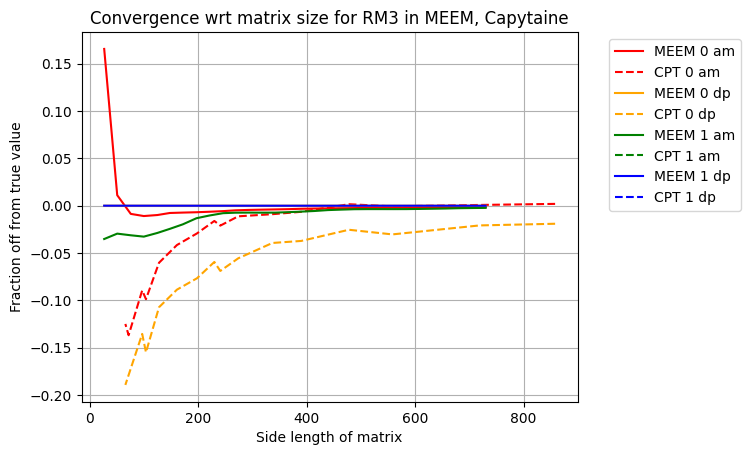

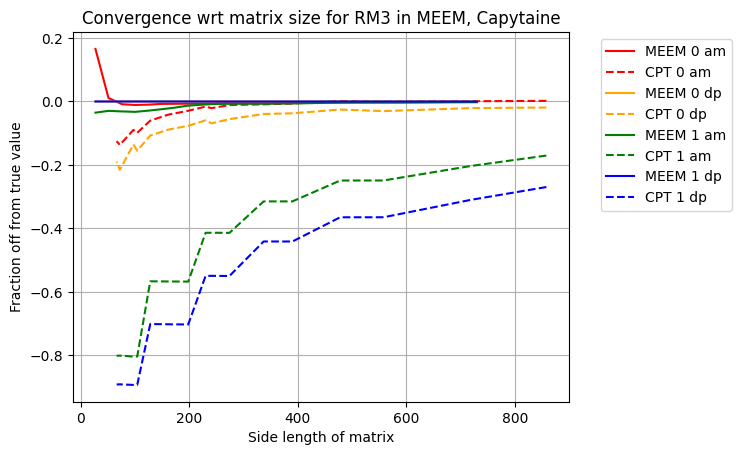

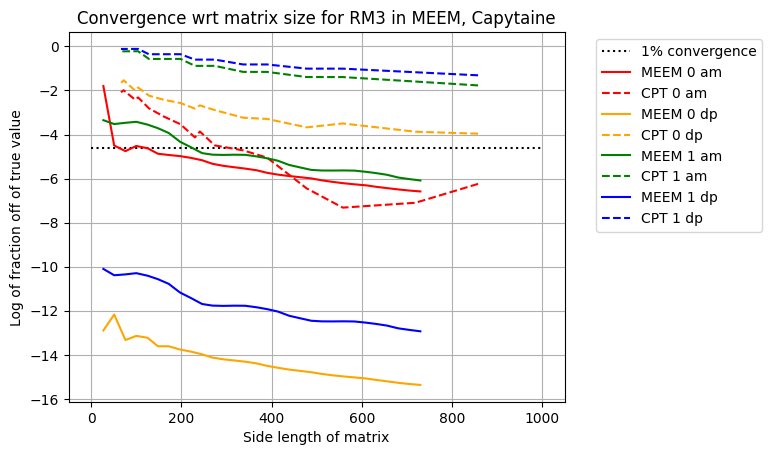

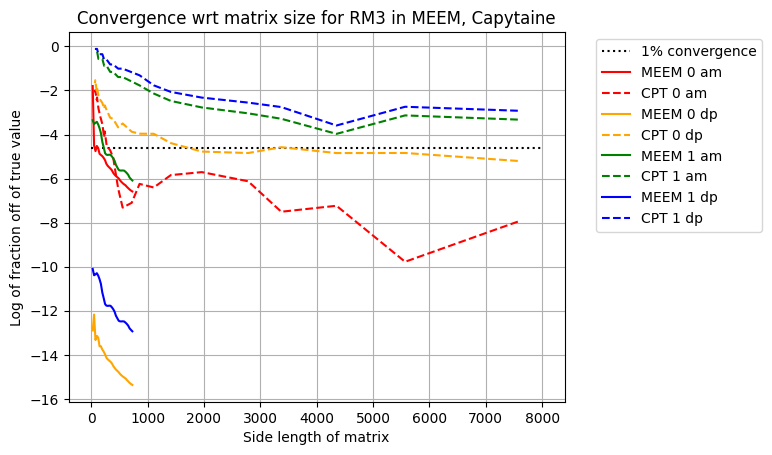

In [ ]:
# Plots for file3
base_data = cpt_data['base']
for m0_index in range(2):
  print("m0 =", base_data["m0s"][m0_index])
  data = get_plottable_info(comparison_data, 0, base_data, base_data["m0s"][m0_index])
  all_labels = [" 0 am", " 0 dp", " 1 am", " 1 dp"]
  plot_both_against_fraction(data, 1000, all_labels, vtrunc = 0.2)
  plot_both_against_fraction(data, 1000, all_labels, vtrunc = 1)
  plot_both_against_fraction(data, 1000, all_labels, vtrunc = 1, logs = True)
  plot_both_against_fraction(data, 8000, all_labels, vtrunc = 1, logs = True)

In [ ]:
# file2 specific helpers
def extract_file2_data(cf, m0, heave, hydro):
  subcf = cf[m0][heave]
  true_hydro = subcf[hydro]
  cpt_xs = [data_dict["Panel Count"] for data_dict in subcf["cpt"]]
  meem_xs = [(data_dict["NMK"][0] + 2 * data_dict["NMK"][1] + data_dict["NMK"][2]) for data_dict in subcf["MEEM"]]
  cpt_fracs = [abs(data_dict[hydro] - true_hydro)/true_hydro for data_dict in subcf["cpt"]]
  meem_fracs = [abs(data_dict[hydro] - true_hydro)/true_hydro for data_dict in subcf["MEEM"]]
  return cpt_xs, meem_xs, cpt_fracs, meem_fracs

def plot_dims_with_fraction(cf_lst, m0, heave, hydro, dim_func, dim_name, trunc, vtrunc = None, logs = False):
  colors = ["orange", "green", "blue"]
  if logs:
    plt.hlines(np.log(0.01), xmin = 0, xmax = trunc, color = "black", linestyle = ":", label = "1% convergence")
  for i in range(3):
    cf = cf_lst[i]
    dim_val = dim_func(cf)
    meem_label = "MEEM " + dim_name + f" {dim_val:.3g}"
    cpt_label = "CPT "  + dim_name + f" {dim_val:.3g}"
    cpt_xs, meem_xs, cpt_fracs, meem_fracs = extract_file2_data(cf, m0, heave, hydro)
    xs, ys = trunc_to_matrix_size(trunc, meem_xs, meem_fracs, vtrunc, logs)
    plt.plot(xs, ys, color = colors[i], label = meem_label, linestyle = "-")
    xs, ys = trunc_to_matrix_size(trunc, cpt_xs, cpt_fracs, vtrunc, logs)
    plt.plot(xs, ys, color = colors[i], label = cpt_label, linestyle = "--")
  plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1)) 
  plt.grid()
  plt.xlabel("Side length of matrix")
  ylab = "Fraction off from true value" if not logs else "Log of fraction off of true value"
  plt.ylabel(ylab)
  plt.title("Convergence wrt matrix size for RM3 variants, " + hydro + f", heaving region {heave}, m0 = {m0:.1g}")
  plt.show()

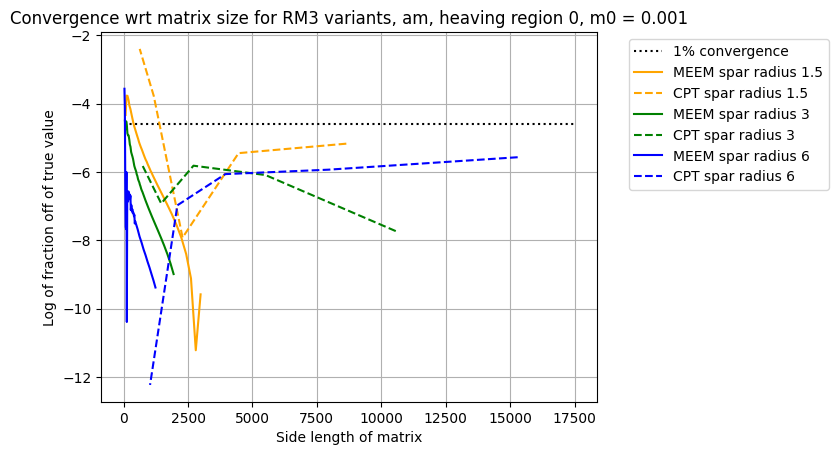

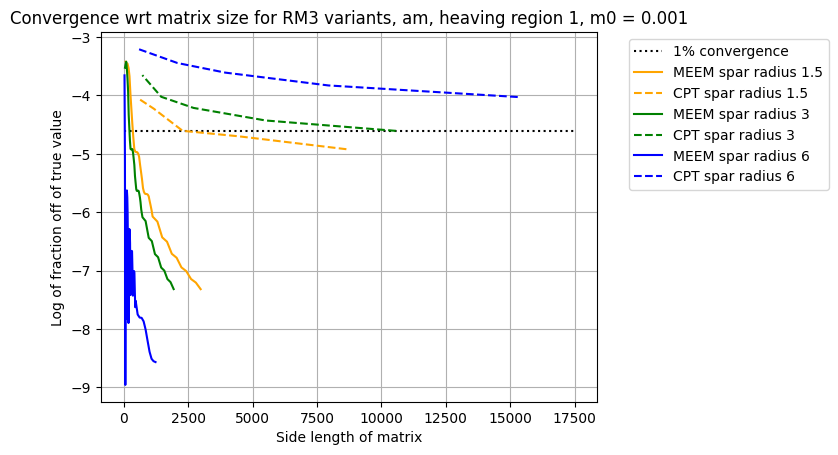

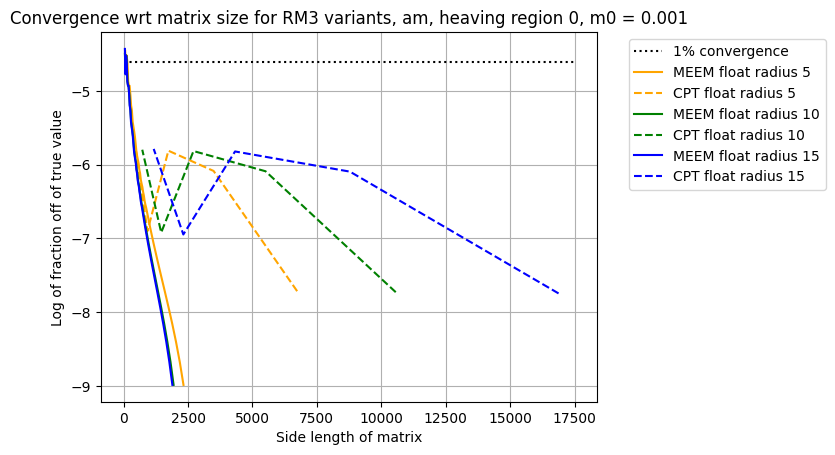

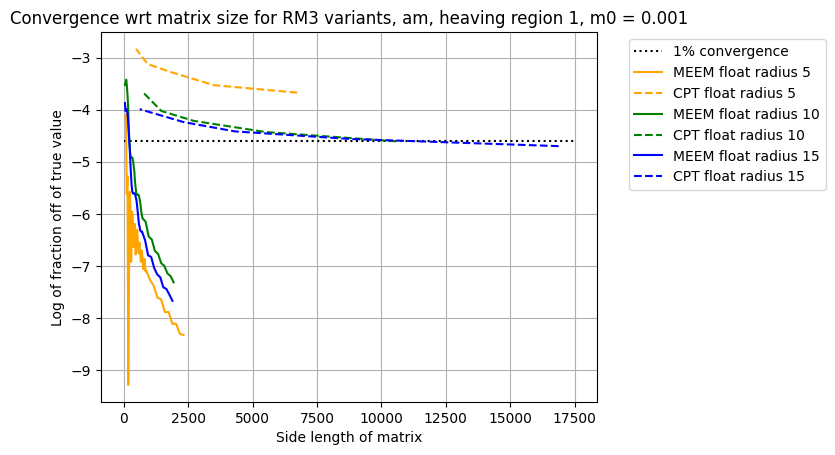

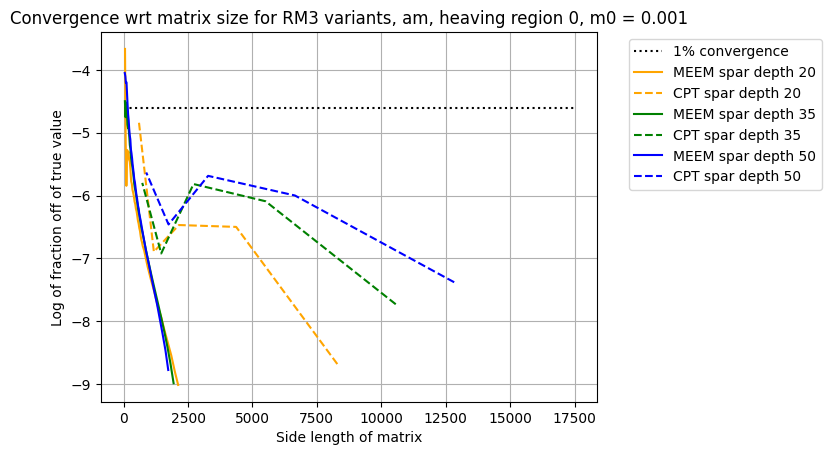

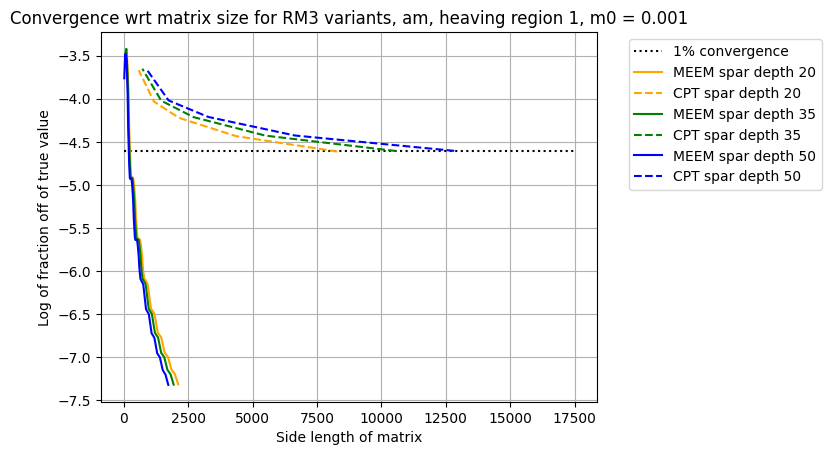

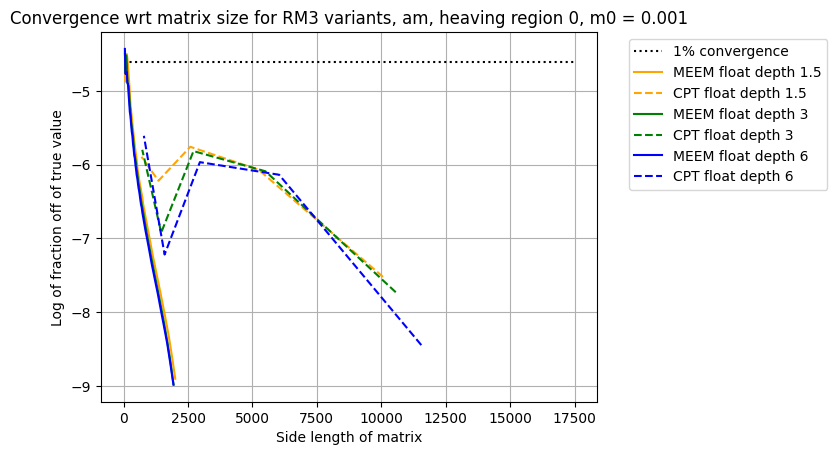

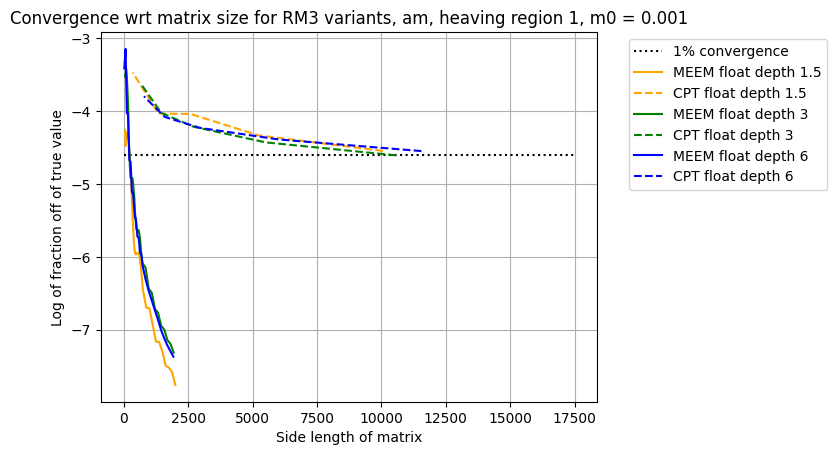

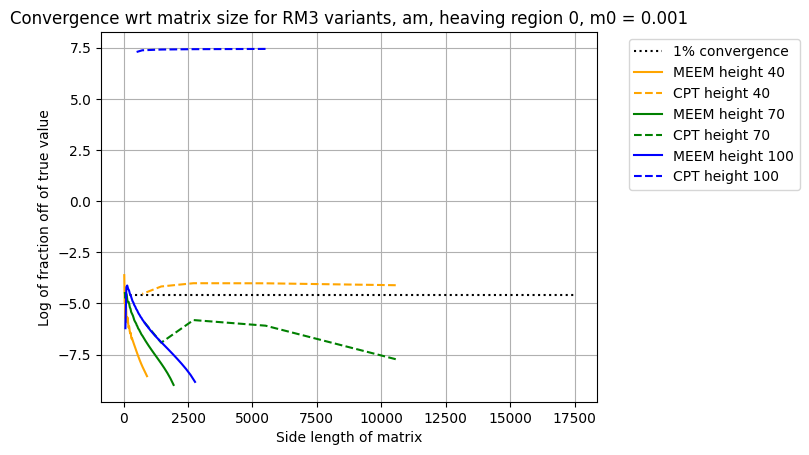

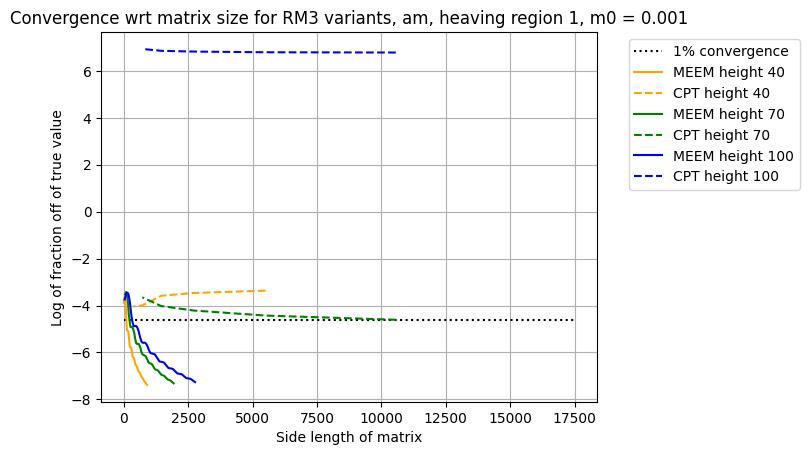

In [ ]:
# file2 plots
cf_base = cpt_data["base"]
dim_info = {0 : ["spar radius", lambda cf: cf["a"][0]],
            1 : ["float radius", lambda cf: cf["a"][1]],
            2 : ["spar depth", lambda cf: cf["d"][0]],
            3 : ["float depth", lambda cf: cf["d"][1]],
            4 : ["height", lambda cf: cf["h"]]}

for i in range(5):
  cf_pair = cpt_data["variants"][i]
  cf_lst = [cf_pair[0], cf_base, cf_pair[1]]
  m0 = cf_base["m0s"][0]
  for heave in range(2):
    plot_dims_with_fraction(cf_lst, m0, heave, "am",
                            dim_info[i][1], dim_info[i][0], 17500, vtrunc = None, logs = True)